# Solving Equilibria with Fixed Axis and Fixed NAE O(rho) Behavior in DESC

This tutorial shows how to find equilibrium solutions in DESC which are constrained to have the same axis and near-axis behavior as a NAE solution from the pyQSC code

# Creating a DESC Equilibrium from a pyQsc Near-Axis Equilibrium

Note that you must have pyQsc installed in order to make use of the `Equilibrium.from_near_axis` method, do so with `pip install qsc`

In [1]:
# must have installed pyQsc with `pip install qsc` in order to use this!
from qsc import Qsc
import numpy as np
from desc.equilibrium import Equilibrium
from desc.objectives import get_fixed_boundary_constraints
from desc.plotting import plot_comparison, plot_fsa, plot_section, plot_surfaces

DESC version 0.7.2+391.g22420f46,using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 22.56 GB available memory


DESC is able to create an equilibrium based off of a `pyQsc` NAE equilibrium object. First, we'll make the NAE equilibrium using `pyQsc`

In [2]:
qsc_eq = Qsc.from_paper('precise QA') 

Then, to make the DESC equilibrium, the `Equilibrium` class has a method `Equilibrium.from_near_axis`. This method creates a DESC `Equilibrium` based off of the `pyQsc` equilibrium. It requires as input the desired DESC FourierZernike resolution, as well as the radius at which you want to evaluate the qsc equilibrium at to make the DESC equilibrium's boundary. The equilibrium's initial `R_lmn`, `Z_lmn` Fourier-Zernike coefficients are fit to the `R,Z` evaluated from the `pyQsc` equilibrium, and the initial `L_lmn` are 0 (because the `pyQsc` equilibrium uses Boozer angles, so there is no poloidal stream function)

In [3]:
ntheta=75
r=0.35
desc_eq = Equilibrium.from_near_axis(qsc_eq, # the Qsc equilibrium object 
                                     r= r, # the finite radius (m) at which to evaluate the Qsc surface to use as the DESC boundary
                                     L=8, # DESC radial resolution
                                     M=8, # DESC poloidal resolution
                                     N=8, # DESC toroidal resolution
                                     ntheta=ntheta)
eq_fit = desc_eq.copy() # copy so we can see the original Qsc surfaces later


Now we solve the equilibrium as normal in DESC

In [4]:
# get the fixed-boundary constraints, which include also fixing the pressure and fixing the current profile (iota=False flag means fix current)
constraints = get_fixed_boundary_constraints(iota=False) 
print(constraints)

# solve the equilibrium
desc_eq.solve(verbose=3, ftol=1e-2,objective="force",maxiter=100,xtol=1e-6,constraints=constraints);

# Save equilibrium as .h5 file
desc_eq.save("DESC_from_NAE_precise_QA_output.h5")

(<desc.objectives.linear_objectives.FixBoundaryR object at 0x7f4b2c11e790>, <desc.objectives.linear_objectives.FixBoundaryZ object at 0x7f4b2c11eca0>, <desc.objectives.linear_objectives.FixLambdaGauge object at 0x7f4b2c11e430>, <desc.objectives.linear_objectives.FixPsi object at 0x7f4b2c11e280>, <desc.objectives.linear_objectives.FixPressure object at 0x7f4b2c11e400>, <desc.objectives.linear_objectives.FixCurrent object at 0x7f4b2c11ea90>)
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 324 ms
Timer: Objective build = 2.58 sec
Timer: Linear constraint projection build = 5.60 sec
Compiling objective function and derivatives
Timer: Objective compilation time = 3.42 sec
Timer: Jacobian compilation time = 9.11 sec
Timer: Total compilation time = 12.5 sec
Number of parameters: 848
Number of objectives: 5346
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9893

Now we have a DESC equilibrium solved with the boundary from `pyQsc`. It has zero toroidal current as its profile constraint along with zero pressure since the original Qsc equilibrium had 0 pressure and current.

(<Figure size 864x864 with 2 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

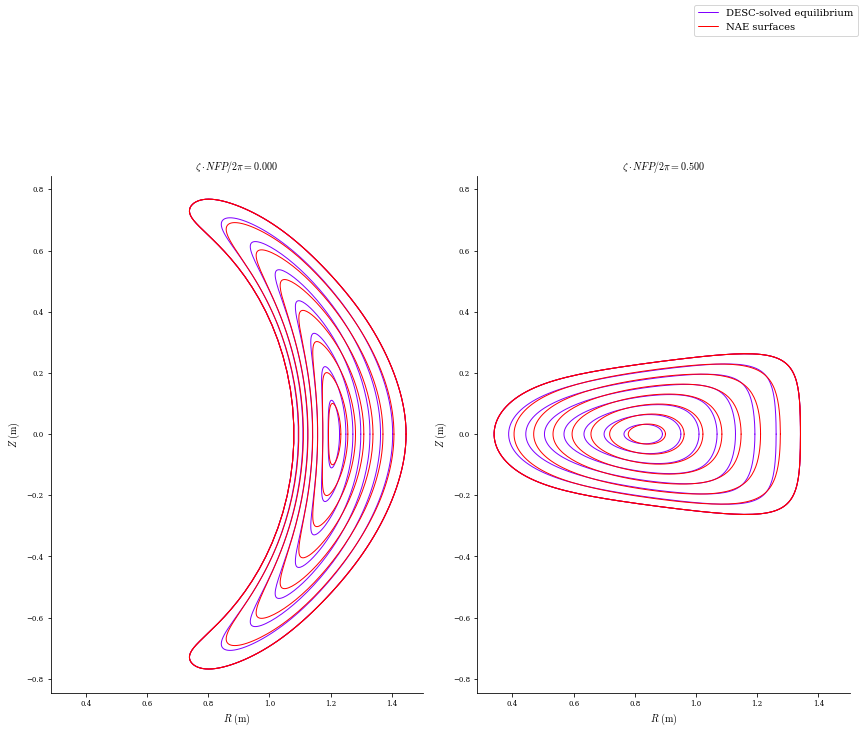

In [5]:
plot_comparison(eqs=[desc_eq,eq_fit],labels=["DESC-solved equilibrium","NAE surfaces"],zeta=2,figsize=(12,12),theta=0)

# Solving Equilibria with Fixed Axis and Fixed NAE O(rho) Behavior in DESC

In [6]:

# utility functions for getting the NAE constraints
from desc.objectives.utils import get_equilibrium_objective, get_NAE_constraints
eq_NAE = eq_fit.copy()

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 185 ms
Timer: Objective build = 479 ms
Timer: Linear constraint projection build = 3.98 sec
Compiling objective function and derivatives
Timer: Objective compilation time = 3.53 sec
Timer: Jacobian compilation time = 9.24 sec
Timer: Total compilation time = 12.7 sec
Number of parameters: 714
Number of objectives: 5346
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9997e+01                                    2.85e+04    
       1              5         8.4198e+00      3.16e+01       1.00e-02       7.67e+03    
       2              6         7.8916e-01      7.63e+00       1.34e-02       3.05e+03    
       3              7         1.7073e-01      6.18e-01       2.05e-02       1.76e+03    
       4              8         7.5796e-02      9.49e-02       3.85e-02       1.12e+03    
       5              9      

(<Figure size 864x864 with 1 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 1.875$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

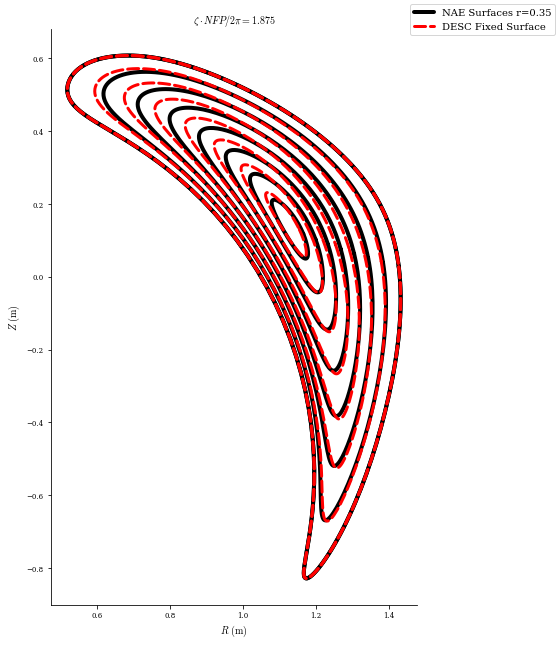

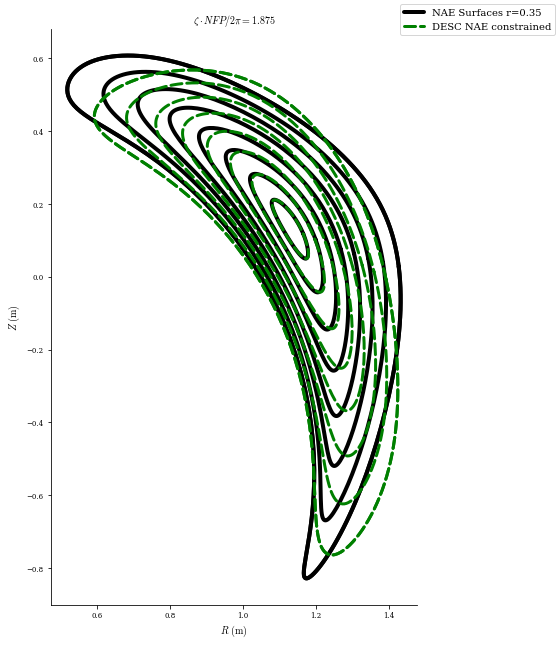

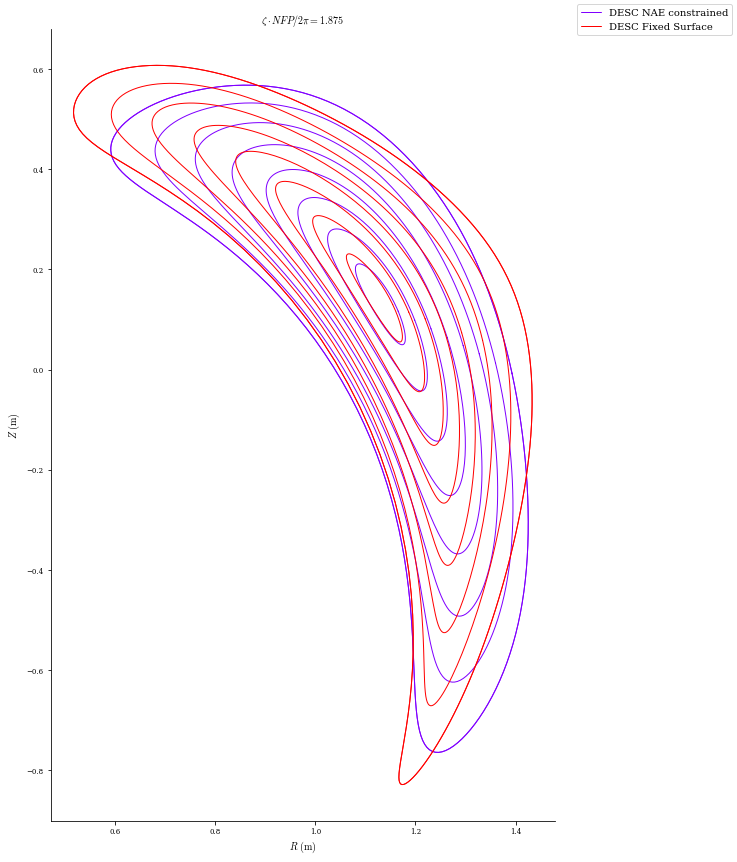

In [7]:
cs = get_NAE_constraints(desc_eq,qsc_eq,iota=False,order=1) 
# this has all the constraints we need, iota=False specifies we want to fix current instead of iota



eq_NAE.solve(verbose=3, ftol=1e-2,objective="force",maxiter=100,xtol=1e-6,constraints=cs);
# plot_comparison(eqs=[desc_eq,eq_surf],labels=[f'fixed axis and O(r) coeffs','r=0.1 fixed surf'],zeta=1,figsize=(12,12),theta=0)
# plot_comparison(eqs=[desc_eq,eq_fit],labels=[f'fixed axis and O(r) coeffs','NAE'],zeta=1,figsize=(12,12),theta=0)
# plot_comparison(eqs=[eq_fit,eq_surf],labels=[f'NAE','r=0.1 fixed surf'],zeta=1,figsize=(12,12),theta=0)

fig,ax = plot_comparison(eqs=[eq_fit,desc_eq],labels=[f'NAE Surfaces r={r}', 'DESC Fixed Surface'],colors=['k','r'],linestyles=['-','--'],zeta=np.pi/desc_eq.NFP*3.75,figsize=(9,9),theta=0,lws=[4,3,3])
fig,ax = plot_comparison(eqs=[eq_fit,eq_NAE],labels=[f'NAE Surfaces r={r}',f'DESC NAE constrained'],colors=['k','g'],linestyles=['-','--'],zeta=np.pi/desc_eq.NFP*3.75,figsize=(9,9),theta=0,lws=[4,3,3])
fig,ax = plot_comparison(eqs=[desc_eq,eq_NAE],labels=[f'DESC Fixed Surface',f'DESC NAE constrained'],colors=['k','g'],linestyles=['-','--'],zeta=np.pi/desc_eq.NFP*3.75,figsize=(9,9),theta=0,lws=[4,3,3])



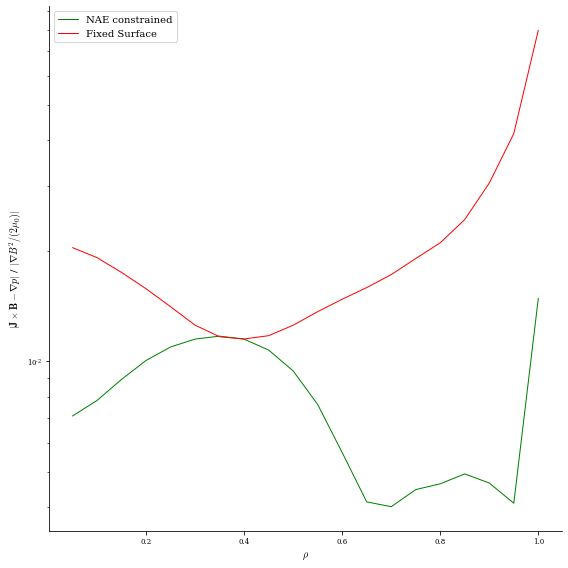

In [8]:
fig,ax = plot_fsa(eq_NAE,'|F|',label='NAE constrained',linecolor='g',log=True,norm_F=True,figsize=(8,8))

fig,ax = plot_fsa(desc_eq,'|F|',label='Fixed Surface',linecolor='r',log=True,norm_F=True,ax=ax)
ax.legend()